<a href="https://colab.research.google.com/github/tylergusmyers/ML_token_prices/blob/main/SOL_Pricing_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model for predicting SOL-USD prices.

In [2]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

Step 1: Import the SOL-USD OHLCV dataset into a Pandas DataFrame.

In [3]:
# Import the SOL_USD OHLCV dataset into a Pandas Dataframe

from google.colab import files

csv_file = files.upload()


Saving SOL-USD.csv to SOL-USD.csv


In [7]:
# Read the SOL_USD.csv file from the Resources folder into a Pandas DataFrame
sol_data_df = pd.read_csv("SOL-USD.csv",
                          index_col='Date', 
                          infer_datetime_format=True, 
                          parse_dates=True)

# Review the DataFrame
sol_data_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-10,0.832005,1.313487,0.694187,0.951054,0.951054,87364276
2020-04-11,0.951054,1.049073,0.765020,0.776819,0.776819,43862444
2020-04-12,0.785448,0.956670,0.762426,0.882507,0.882507,38736897
2020-04-13,0.890760,0.891603,0.773976,0.777832,0.777832,18211285
2020-04-14,0.777832,0.796472,0.628169,0.661925,0.661925,16747614


In [8]:
# Filter the date index and close columns
signals_df = sol_data_df.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns
Date,,
2020-04-11,0.776819,-0.183202
2020-04-12,0.882507,0.136052
2020-04-13,0.777832,-0.118611
2020-04-14,0.661925,-0.149013
2020-04-15,0.646651,-0.023075


,Close,Actual Returns
Date,,
2022-01-07,136.402817,-0.093255
2022-01-08,142.513458,0.044798
2022-01-09,140.839005,-0.011749
2022-01-10,135.954941,-0.034678
2022-01-11,140.183853,0.031105


Step 2: Generate trading signals using short- and long-window SMA values.

In [10]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['Close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['Close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2020-07-19,0.920349,-0.047832,0.934303,0.690508
2020-07-20,0.873089,-0.051350,0.934465,0.691471
2020-07-21,0.977166,0.119205,0.934297,0.692418
2020-07-22,1.044087,0.068485,0.953673,0.695080
2020-07-23,1.049844,0.005514,0.986047,0.698959


,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2022-01-07,136.402817,-0.093255,152.468201,190.757964
2022-01-08,142.513458,0.044798,146.111839,190.772408
2022-01-09,140.839005,-0.011749,142.546658,190.563974
2022-01-10,135.954941,-0.034678,138.927555,190.232594
2022-01-11,140.183853,0.031105,139.872814,189.908541


In [11]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2020-07-19,0.920349,-0.047832,0.934303,0.690508,-1.0
2020-07-20,0.873089,-0.051350,0.934465,0.691471,-1.0
2020-07-21,0.977166,0.119205,0.934297,0.692418,1.0
2020-07-22,1.044087,0.068485,0.953673,0.695080,1.0
2020-07-23,1.049844,0.005514,0.986047,0.698959,1.0


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2022-01-07,136.402817,-0.093255,152.468201,190.757964,-1.0
2022-01-08,142.513458,0.044798,146.111839,190.772408,1.0
2022-01-09,140.839005,-0.011749,142.546658,190.563974,-1.0
2022-01-10,135.954941,-0.034678,138.927555,190.232594,-1.0
2022-01-11,140.183853,0.031105,139.872814,189.908541,1.0


In [12]:
signals_df['Signal'].value_counts()

 1.0    284
-1.0    258
Name: Signal, dtype: int64

In [13]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2020-07-19,0.920349,-0.047832,0.934303,0.690508,-1.0,NaN
2020-07-20,0.873089,-0.051350,0.934465,0.691471,-1.0,0.051350
2020-07-21,0.977166,0.119205,0.934297,0.692418,1.0,-0.119205
2020-07-22,1.044087,0.068485,0.953673,0.695080,1.0,0.068485
2020-07-23,1.049844,0.005514,0.986047,0.698959,1.0,0.005514


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2022-01-07,136.402817,-0.093255,152.468201,190.757964,-1.0,0.093255
2022-01-08,142.513458,0.044798,146.111839,190.772408,1.0,-0.044798
2022-01-09,140.839005,-0.011749,142.546658,190.563974,-1.0,-0.011749
2022-01-10,135.954941,-0.034678,138.927555,190.232594,-1.0,0.034678
2022-01-11,140.183853,0.031105,139.872814,189.908541,1.0,-0.031105


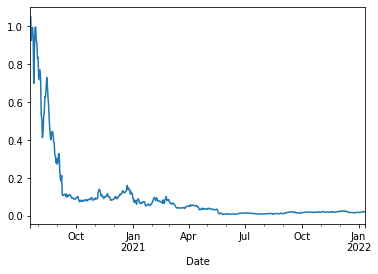

In [14]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

Step 3: Split the data into training and testing datasets.

In [15]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
Date,,
2020-07-20,0.934303,0.690508
2020-07-21,0.934465,0.691471
2020-07-22,0.934297,0.692418
2020-07-23,0.953673,0.695080
2020-07-24,0.986047,0.698959


In [16]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    284
-1.0    258
Name: Signal, dtype: int64

In [17]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2020-07-20 00:00:00


In [18]:
# Select the ending period for the training data with an offset of 3 months / 6 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2020-10-20 00:00:00


In [19]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
Date,,
2020-07-20,0.934303,0.690508
2020-07-21,0.934465,0.691471
2020-07-22,0.934297,0.692418
2020-07-23,0.953673,0.695080
2020-07-24,0.986047,0.698959


In [20]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
Date,,
2020-07-20,0.934303,0.690508
2020-07-21,0.934465,0.691471
2020-07-22,0.934297,0.692418
2020-07-23,0.953673,0.695080
2020-07-24,0.986047,0.698959


In [21]:
X_train.tail()

,SMA_Fast,SMA_Slow
Date,,
2020-10-16,2.393263,2.541025
2020-10-17,2.283842,2.554551
2020-10-18,2.233075,2.568035
2020-10-19,2.207983,2.581042
2020-10-20,2.155894,2.592377


In [22]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)